In [1]:
%load_ext autoreload
%autoreload 2

import functools
import time

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import gpjax as gpx
import optax

from bay_sbi import embedding_models
from bay_sbi import maf_flow
from bay_sbi import train
from bay_sbi import two_moons

jax.devices()

2024-11-04 11:36:41.612099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 11:36:41.627827: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 11:36:41.632250: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 11:36:43.276674: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1730738207.334515   71050 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[gpu(id=0)]

## Problem Setup

In [2]:
draw_batch = jax.jit(jax.vmap(two_moons.draw_joint_two_moons))
draw_obs = jax.jit(jax.vmap(two_moons.draw_two_moons, in_axes=[0, None]))
draw_obs_conds = jax.jit(jax.vmap(two_moons.draw_two_moons))
draw_thetas = jax.jit(jax.vmap(two_moons.draw_param, in_axes=[0, None]))
draw_thetas_cond = jax.jit(jax.vmap(two_moons.draw_param))

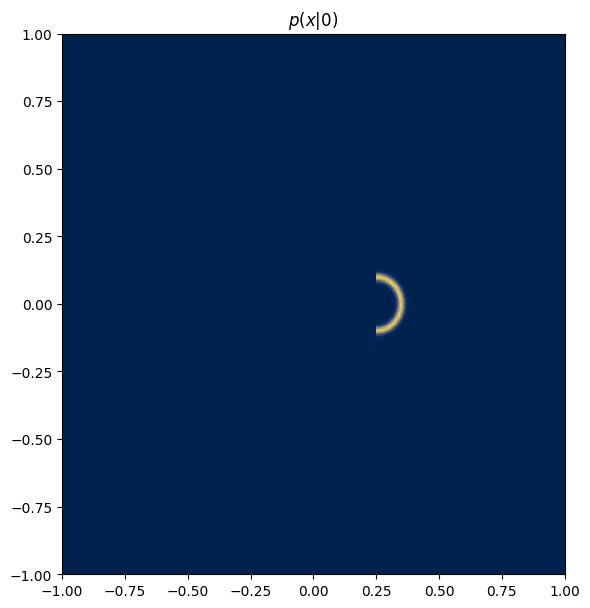

In [3]:
# Plot some distributions to get a sense of the two moons problem
batch_size = 1_000_000
rng = jax.random.PRNGKey(0)
rng_batch = jax.random.split(rng, batch_size)
x_samples = draw_obs(rng_batch, jnp.array([0.0, 0.0]))

fig = plt.figure(figsize=(6, 6))
n_bins = 1000
plt.hist2d(
    x_samples[:, 0], x_samples[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.title(r'$p(x|0)$')
plt.show()

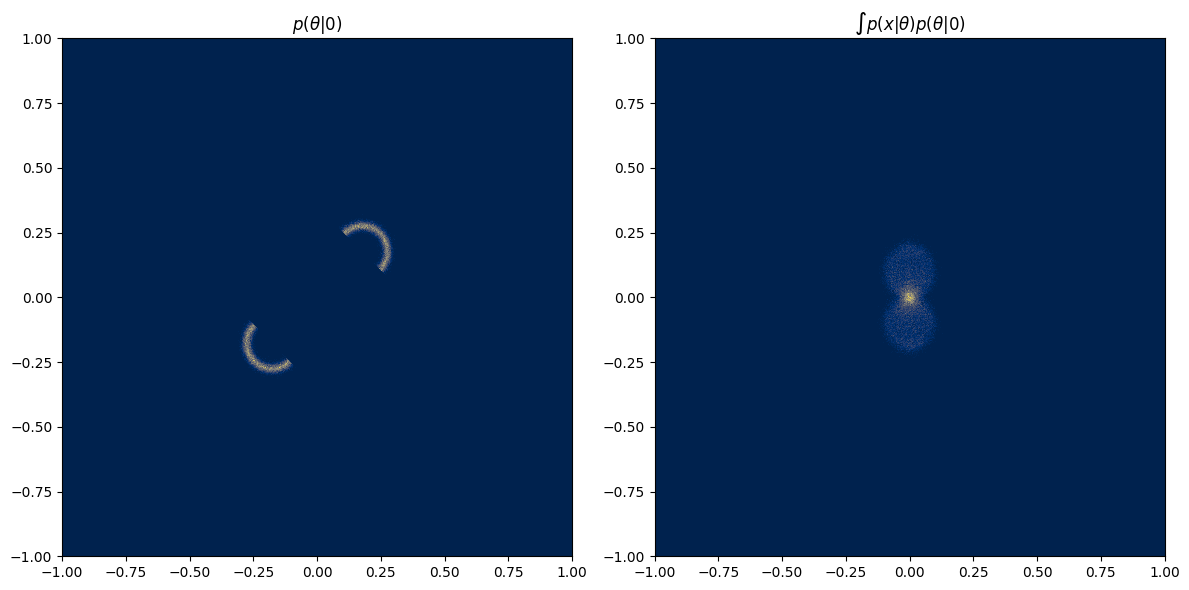

In [4]:
# Plot our target distribution for our context of 0.
batch_size = 100_000
rng = jax.random.PRNGKey(0)
rng_batch = jax.random.split(rng, batch_size)
theta_p_x = draw_thetas(rng_batch, jnp.array([0.0, 0.0]))
x_p_x = draw_obs_conds(rng_batch, theta_p_x)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
n_bins = 1000
ax[0].set_title(r'$p(\theta|0)$')
ax[0].hist2d(
    theta_p_x[:, 0], theta_p_x[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
ax[1].set_title(r'$\int p(x|\theta)p(\theta|0)$')
ax[1].hist2d(
    x_p_x[:, 0], x_p_x[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)
plt.tight_layout()
plt.show()

## Training Setup

In [5]:
parameter_dim = 2
n_maf_layers = 5
hidden_dims_maf = [50, 50]
hidden_layers_mlp = []
activation_mlp ='gelu'
activation_maf = 'tanh'
context_dim = 2

embedding_module = embedding_models.MLP(context_dim, hidden_layers_mlp, activation_mlp)
maf_model = maf_flow.MAF(parameter_dim, n_maf_layers, hidden_dims_maf, activation_maf)
model = maf_flow.EmbeddedFlow(embedding_module, maf_model)

# Initialize the train state.
rng = jax.random.PRNGKey(1)
optimizer = 'adam'
learning_rate = 1e-3
learning_rate_schedule = optax.exponential_decay(learning_rate, 1.0, 1.0)
state = train.create_train_state_nf(rng, optimizer, model, context_dim, parameter_dim, learning_rate_schedule)
sample_func = jax.jit(
    functools.partial(state.apply_fn, method='sample', mutable=('batch_stats',)),
    static_argnames=['sample_shape',]
)
log_prob_func = jax.jit(
    functools.partial(state.apply_fn, mutable=('batch_stats',))
)

# If you change the underlying model, you must create a new train_step function since it depends on the
# optimizer mask which depends on the maf_model structure.
train_step = jax.jit(train.train_step, static_argnames=['learning_rate_schedule', 'n_atoms'])

In [476]:
batch_size = 1024
x_obs = jnp.zeros((1, 2))

n_atoms = 128
steps_per_epoch = 10
n_steps = steps_per_epoch * 200

def train_state(theta_samp_func, rng, prev_state = None, verbose = False):

    mu_prior = jnp.zeros(2)
    prec_prior = jnp.zeros((2, 2)) # Equivalent to uniform prior.

    sample_shape = (4096,)
    max_width = len(str(n_steps))
    theta_batch_samps = []
    kl = []

    train_metrics_last_t = time.time()

    # Create fresh state
    learning_rate = 1e-3
    learning_rate_schedule = optax.exponential_decay(
        learning_rate, steps_per_epoch, 1.0
    )
    if prev_state is None:
        state = train.create_train_state_nf(
            rng, optimizer, model, context_dim, parameter_dim,
            learning_rate_schedule
        )
    else:
        state = prev_state

    for step in range(n_steps):

        # Sample a batch
        rng, _ = jax.random.split(rng)
        rng_batch = jax.random.split(rng, batch_size)

        theta_batch = theta_samp_func(rng)
        x_batch = draw_obs_conds(rng_batch, theta_batch)
        batch = {'truth': theta_batch, 'context': x_batch}

        # Update
        state, metrics = train_step(
            rng, state, batch, mu_prior, prec_prior,
            learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms
        )
        if step > 0 and step % steps_per_epoch == 0:
            metrics['steps_per_second'] = (
                steps_per_epoch / (time.time() - train_metrics_last_t)
            )
            train_metrics_last_t = time.time()
            log_obs_prob, _ = log_prob_func(
                {'params': state.params, 'batch_stats': state.batch_stats},
                theta_p_x, jnp.zeros_like(x_p_x)
            )
            metrics['kl'] = -jnp.mean(log_obs_prob)
            if verbose:
                print(f'step {step:>{max_width}}:', jax.tree_map(lambda x: f'{float(x):.3g}', metrics))
            t_samp, _ = sample_func(
                {'params': state.params, 'batch_stats': state.batch_stats},
                rng, x_obs,
                sample_shape=sample_shape
            )
            theta_batch_samps.append(jnp.squeeze(t_samp))
            kl.append(-jnp.mean(log_obs_prob))

    # Log the final performance
    log_obs_prob, _ = log_prob_func(
        {'params': state.params, 'batch_stats': state.batch_stats},
        theta_p_x, jnp.zeros_like(x_p_x)
    )
    t_samp, _ = sample_func(
        {'params': state.params, 'batch_stats': state.batch_stats},
        rng, x_obs,
        sample_shape=sample_shape
    )
    theta_batch_samps.append(jnp.squeeze(t_samp))
    kl.append(-jnp.mean(log_obs_prob))

    return state, theta_batch_samps, kl

## Base model

### TODO
- Overplot distribution on top of posterior predictions.
- Pick and omega that has a chance (mixture of two Gaussians)
- Use a mixture MAF to make the two moons problem more tractable
- Build schedule on sampling from flow and do Bayesian optimization on that problem
- Experiment with hot starts
- Write notes on our current strategy

In [477]:
theta_samp_func = functools.partial(
    jax.random.uniform, shape=(batch_size, 2), minval=-1.0, maxval=1.0
)
rng = jax.random.PRNGKey(2)
final_state_broad, theta_batch_broad, kl_broad = train_state(theta_samp_func, rng)

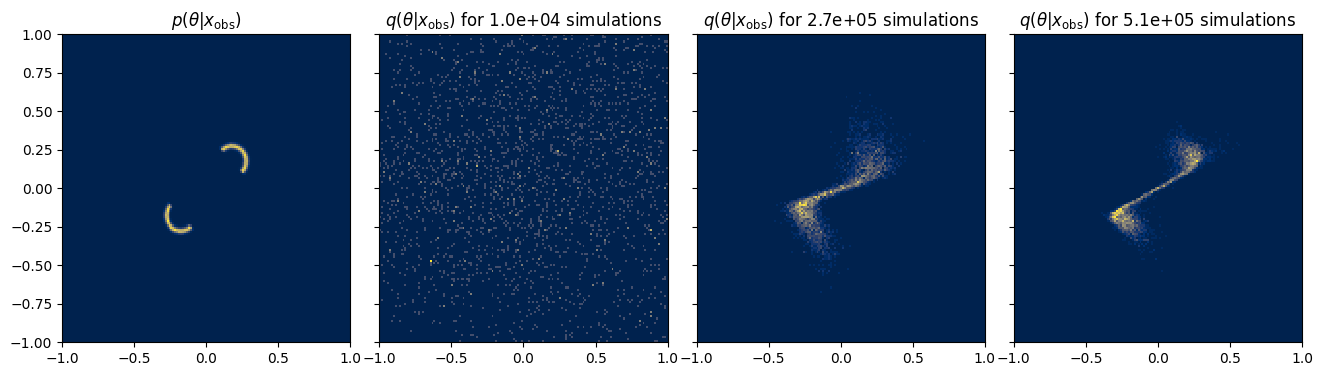

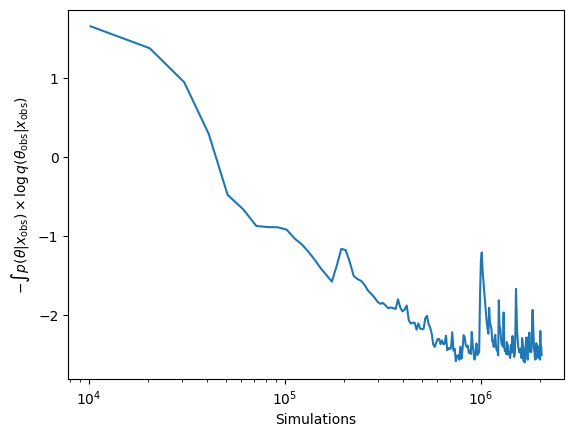

In [478]:
plt_indices = [0, 25, 49]
fig, ax = plt.subplots(
    1, len(plt_indices) + 1, figsize=(4 * (len(plt_indices) + 1),4), sharey=True,
    gridspec_kw={'hspace': 0.02,'wspace':0.1}, dpi=100
)
n_bins = 150

ax[0].set_title(r'$p(\theta|x_\mathrm{obs})$')
ax[0].hist2d(
    theta_p_x[:, 0], theta_p_x[:, 1],
    bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
)

for plt_i, i in enumerate(plt_indices):
    ax[plt_i+1].set_title(r'$q(\theta|x_\mathrm{obs})$ ' + f'for {batch_size * steps_per_epoch * (i+1):.1e} simulations')
    ax[plt_i+1].hist2d(
        theta_batch_broad[i][:, 0], theta_batch_broad[i][:, 1],
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
plt.show()

plt.plot(jnp.arange(1, n_steps// steps_per_epoch + 1) * steps_per_epoch * batch_size, jnp.array(kl_broad))
plt.xlabel('Simulations')
plt.xscale('log')
plt.ylabel(r'$-\int p(\theta|x_\mathrm{obs}) \times \log q(\theta_\mathrm{obs}|x_\mathrm{obs})$')
plt.show()

# Bayesian Optimization

In [512]:
import numpy as np

# Create Gaussian function that determines
def gaussian_func(hyperparameters):
    mean, log_std = jnp.split(hyperparameters, 2)
    std = jnp.exp(log_std)
    return functools.partial(
        jax.random.multivariate_normal, mean=mean,
        cov=jnp.diag(std),
        shape=(batch_size,)
    )

rng = jax.random.PRNGKey(2)
omega_list = jnp.array([
    [0.25, 0.25, jnp.log(0.2), jnp.log(0.2)],
    [0.25, -0.25, jnp.log(0.8), jnp.log(0.8)],
    [0.5, -0.5, jnp.log(0.6), jnp.log(0.6)],
    [-0.25, 0.25, jnp.log(0.4), jnp.log(0.4)],
    [-0.5, 0.5, jnp.log(0.2), jnp.log(0.2)],
])
f_omega = []
state_list = []
for omega in omega_list:
    rng, _ = jax.random.split(rng)
    state, _, kl_curr = train_state(gaussian_func(omega), rng)
    f_omega.append(np.mean(kl_curr[-5:]))
    state_list.append(state)
f_omega = jnp.array(f_omega)

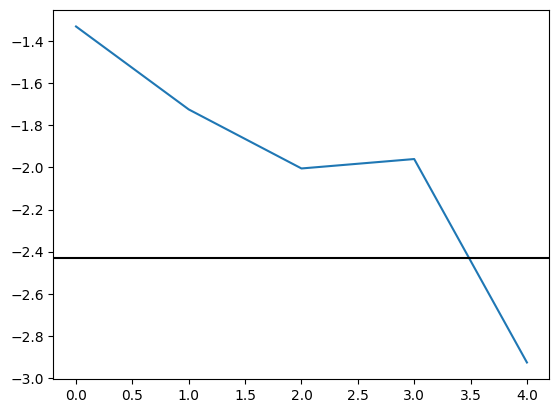

In [513]:
plt.plot(f_omega)
plt.axhline(np.mean(kl_broad[-5:]), c='k')

In [514]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel
from scipy.stats import norm

def expected_improvement(mean, sigma, f_prime):
    a_ei = (f_prime - mean) * norm.cdf(f_prime, loc=mean, scale=sigma)
    a_ei += sigma ** 2 * norm.pdf(f_prime, loc=mean, scale=sigma)
    return a_ei

In [515]:
def get_new_gp():
    kernel = ConstantKernel(1.0, (1e-1, 1e1)) * RBF(1e0, (1e-1, 1e2)) + WhiteKernel(1e-2, (1e-3, 1e0))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-10)
    return gp
gp = get_new_gp()
gp.fit(omega_list, f_omega)
gp.kernel_

/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


1.97**2 * RBF(length_scale=100) + WhiteKernel(noise_level=0.346)

In [516]:
num_points = 10_000
X_test = jax.random.uniform(rng, shape=(num_points, omega_list.shape[1]), minval=-2.0, maxval=2.0)
X_test = jnp.concatenate([omega_list, X_test], axis=0)
mean, sigma = gp.predict(X_test, return_std=True)

X_print_list = []
for i in range(omega_list.shape[1]):
    X_print = np.zeros(X_test.shape)
    X_print[:, i] = np.linspace(-2.0, 2.0, X_test.shape[0])
    X_print_list.append(X_print)

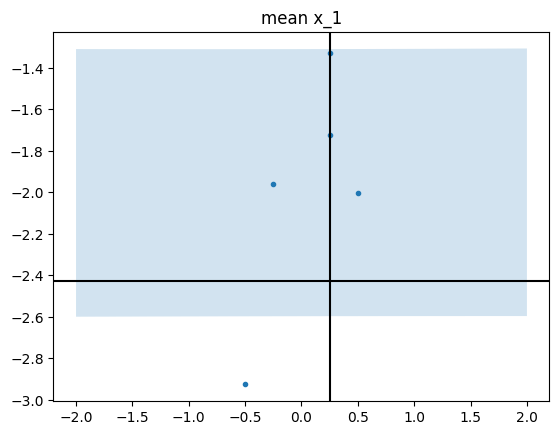

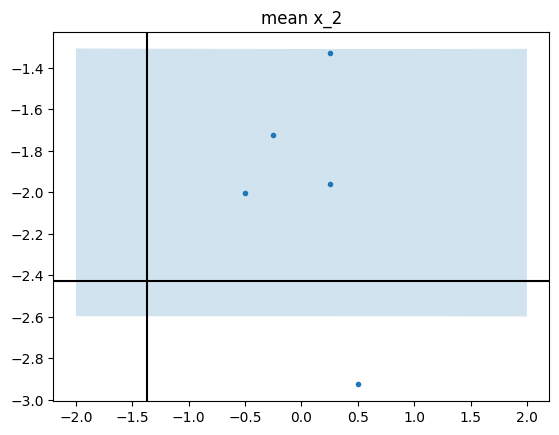

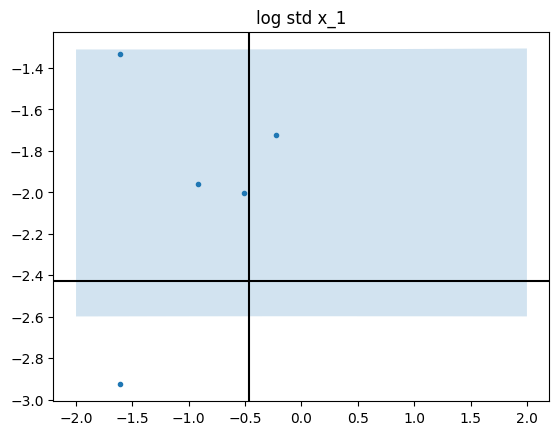

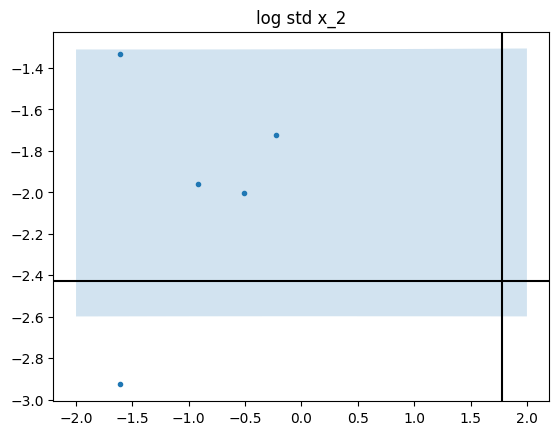

In [517]:
param_print_names = ['mean x_1', 'mean x_2', 'log std x_1', 'log std x_2']
for i in range(omega_list.shape[1]):
    X_print = X_print_list[i]
    mean, sigma = gp.predict(X_print, return_std=True)
    sort_order = np.argsort(X_print[:,i])
    plt.axhline(np.mean(kl_broad[-5:]), c='k')
    plt.plot(omega_list[:,i], f_omega, '.')
    plt.fill_between(
        X_print[:,i][sort_order], (mean-sigma)[sort_order], (mean+sigma)[sort_order], alpha=0.2
    )
    plt.axvline(X_test[np.argmax(expected_improvement(mean, sigma, np.min(f_omega))),i], c='k')
    plt.title(param_print_names[i])
    plt.show()

In [518]:
# param_print_names = ['mean x_1', 'mean x_2', 'log std x_1', 'log std x_2']
# for i in range(omega_list.shape[1]):
#     sort_order = np.argsort(X_test[:,i])
#     plt.axhline(np.mean(kl_broad[-5:]), c='k')
#     plt.plot(omega_list[:,i], f_omega, '.')
#     plt.fill_between(
#         X_test[:,i][sort_order], (mean-sigma)[sort_order], (mean+sigma)[sort_order], alpha=0.2
#     )
#     plt.axvline(X_test[np.argmax(expected_improvement(mean, sigma, np.min(f_omega))),i], c='k')
#     plt.title(param_print_names[i])
#     plt.show()

In [519]:
gp = get_new_gp()
gp.fit(omega_list, f_omega)
mean, sigma = gp.predict(X_test, return_std=True)

for i in range(10):
    next_index = np.argmax(expected_improvement(mean, sigma, np.min(f_omega)))
    print(f'iteration {i}, next_index {next_index}')
    print(f'current best f_prime {np.min(f_omega)} compared with {np.mean(kl_broad[-5:])}')
    omega_next = X_test[next_index]
    print('omega_next', omega_next)
    omega_list = np.append(omega_list, omega_next[None], axis=0)

    rng, _ = jax.random.split(rng)
    state, _, kl_curr = train_state(gaussian_func(omega_next), rng)
    f_omega = np.append(f_omega, np.mean(kl_curr[-5:]))
    state_list.append(state)

    gp = get_new_gp()
    gp.fit(omega_list, f_omega)
    mean, sigma = gp.predict(X_test, return_std=True)

/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


iteration 0, next_index 9652
current best f_prime -2.9267191886901855 compared with -2.429736375808716
omega_next [-1.9419832  1.6081553  1.9674749  1.6809158]
iteration 1, next_index 4735
current best f_prime -2.9267191886901855 compared with -2.429736375808716
omega_next [-1.8430939 -1.6342402 -1.7834115 -1.9114828]


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


iteration 2, next_index 3400
current best f_prime -2.9267191886901855 compared with -2.429736375808716
omega_next [-0.7480178  1.0028095 -1.7478247 -1.6806836]
iteration 3, next_index 3911
current best f_prime -2.9267191886901855 compared with -2.429736375808716
omega_next [ 0.18644094  0.75972414 -0.33552647 -1.0183234 ]
iteration 4, next_index 8669
current best f_prime -2.9267191886901855 compared with -2.429736375808716
omega_next [-0.18243074  0.2065649  -1.5984616  -0.28322458]
iteration 5, next_index 898
current best f_prime -2.9267191886901855 compared with -2.429736375808716
omega_next [ 0.1594224  -0.08003426 -1.6027131  -0.34439754]


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


iteration 6, next_index 7522
current best f_prime -2.9267191886901855 compared with -2.429736375808716
omega_next [-0.06091499  0.00458479 -1.3512521  -0.30554008]
iteration 7, next_index 5645
current best f_prime -2.9267191886901855 compared with -2.429736375808716
omega_next [-0.28088188 -0.0376935  -1.3235307  -0.5059061 ]
iteration 8, next_index 5645
current best f_prime -2.9267191886901855 compared with -2.429736375808716
omega_next [-0.28088188 -0.0376935  -1.3235307  -0.5059061 ]
iteration 9, next_index 8760
current best f_prime -2.9267191886901855 compared with -2.429736375808716
omega_next [-0.4994936   0.12365866 -1.7593384  -1.3350582 ]


In [520]:
omega_list, f_omega

(array([[ 0.25      ,  0.25      , -1.609438  , -1.609438  ],
        [ 0.25      , -0.25      , -0.22314353, -0.22314353],
        [ 0.5       , -0.5       , -0.5108256 , -0.5108256 ],
        [-0.25      ,  0.25      , -0.9162907 , -0.9162907 ],
        [-0.5       ,  0.5       , -1.609438  , -1.609438  ],
        [-1.9419832 ,  1.6081553 ,  1.9674749 ,  1.6809158 ],
        [-1.8430939 , -1.6342402 , -1.7834115 , -1.9114828 ],
        [-0.7480178 ,  1.0028095 , -1.7478247 , -1.6806836 ],
        [ 0.18644094,  0.75972414, -0.33552647, -1.0183234 ],
        [-0.18243074,  0.2065649 , -1.5984616 , -0.28322458],
        [ 0.1594224 , -0.08003426, -1.6027131 , -0.34439754],
        [-0.06091499,  0.00458479, -1.3512521 , -0.30554008],
        [-0.28088188, -0.0376935 , -1.3235307 , -0.5059061 ],
        [-0.28088188, -0.0376935 , -1.3235307 , -0.5059061 ],
        [-0.4994936 ,  0.12365866, -1.7593384 , -1.3350582 ]],
       dtype=float32),
 array([-1.3304775 , -1.7245703 , -2.0050027 ,

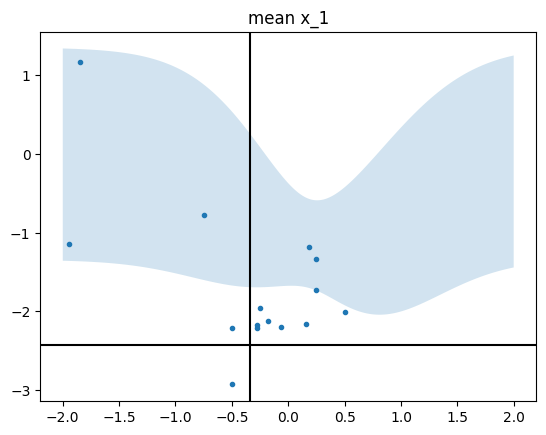

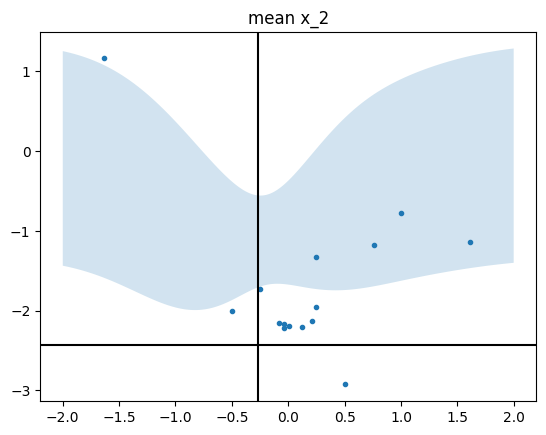

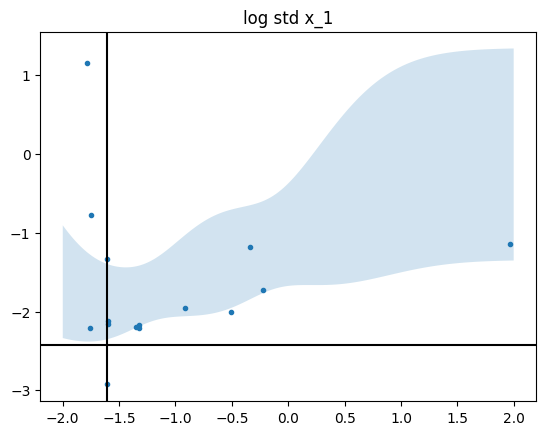

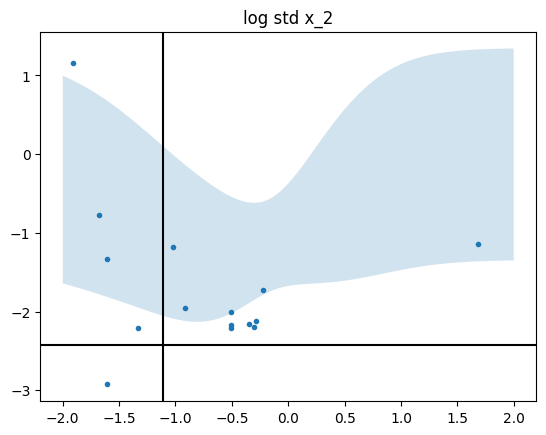

In [521]:
param_print_names = ['mean x_1', 'mean x_2', 'log std x_1', 'log std x_2']
for i in range(omega_list.shape[1]):
    X_print = X_print_list[i]
    mean, sigma = gp.predict(X_print, return_std=True)
    sort_order = np.argsort(X_print[:,i])
    plt.axhline(np.mean(kl_broad[-5:]), c='k')
    plt.plot(omega_list[:,i], f_omega, '.')
    plt.fill_between(
        X_print[:,i][sort_order], (mean-sigma)[sort_order], (mean+sigma)[sort_order], alpha=0.2
    )
    plt.axvline(X_test[np.argmax(expected_improvement(mean, sigma, np.min(f_omega))),i], c='k')
    plt.title(param_print_names[i])
    plt.show()

In [ ]:
param_print_names = ['mean x_1', 'mean x_2', 'log std x_1', 'log std x_2']
for i in range(omega_list.shape[1]):
    sort_order = np.argsort(X_test[:,i])
    plt.axhline(np.mean(kl_broad[-5:]), c='k')
    plt.plot(omega_list[:,i], f_omega, '.')
    plt.fill_between(
        X_test[:,i][sort_order], (mean-sigma)[sort_order], (mean+sigma)[sort_order], alpha=0.2
    )
    plt.axvline(X_test[np.argmax(expected_improvement(mean, sigma, np.min(f_omega))),i], c='k')
    plt.title(param_print_names[i])
    plt.show()

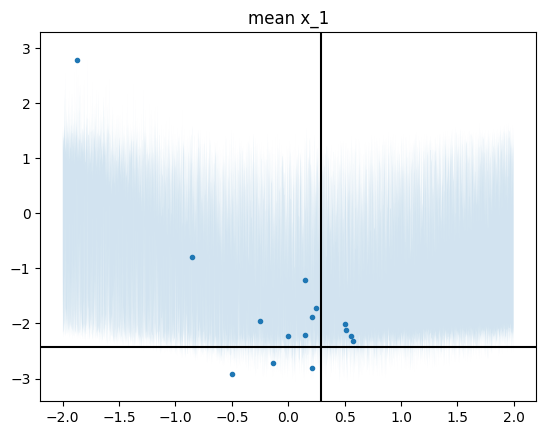

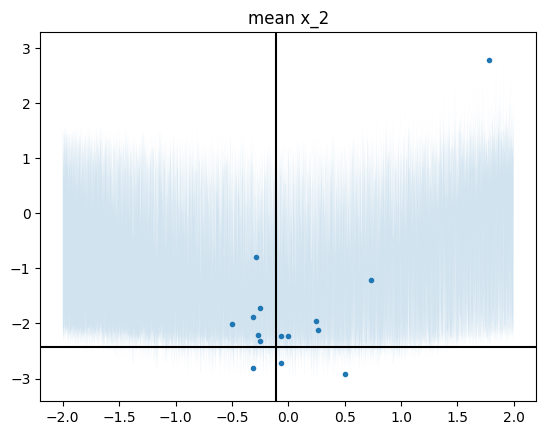

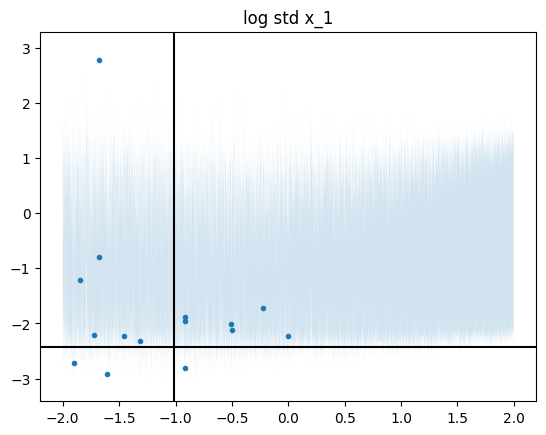

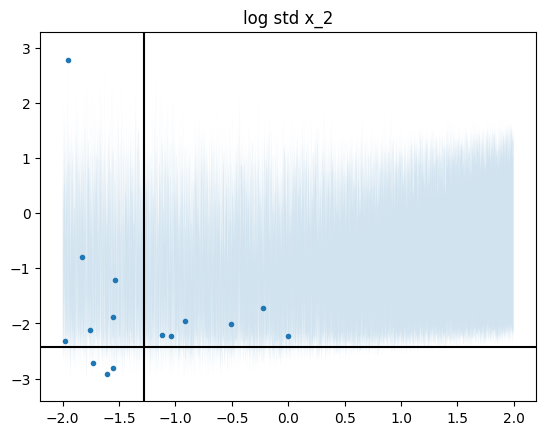

In [494]:
param_print_names = ['mean x_1', 'mean x_2', 'log std x_1', 'log std x_2']
for i in range(omega_list.shape[1]):
    sort_order = np.argsort(X_test[:,i])
    plt.axhline(np.mean(kl_broad[-5:]), c='k')
    plt.plot(omega_list[:,i], f_omega, '.')
    plt.fill_between(
        X_test[:,i][sort_order], (mean-sigma)[sort_order], (mean+sigma)[sort_order], alpha=0.2
    )
    plt.axvline(X_test[np.argmax(expected_improvement(mean, sigma, np.min(f_omega))),i], c='k')
    plt.title(param_print_names[i])
    plt.show()

In [10]:
def gaussian_func(hyperparameters):
    mean, log_std = jnp.split(hyperparameters, 2)
    std = jnp.exp(log_std)
    return functools.partial(
        jax.random.multivariate_normal, mean=mean,
        cov=jnp.diag(std),
        shape=(batch_size,)
    )

rng = jax.random.PRNGKey(2)
omega = []
f = []
omega = jax.random.normal(rng, shape=(5,4))
f_omega = []
for i in range(len(omega)):
    _, _, kl_curr = train_state(gaussian_func(omega[0]), rng)
    f_omega.append(kl_curr[-1])
f_omega = jnp.array(f_omega)


In [11]:
kernel = gpx.kernels.RBF()  # 1-dimensional input
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)
D = gpx.Dataset(omega, f_omega[:,None])

likelihood = gpx.likelihoods.Gaussian(num_datapoints=1)
posterior = prior * likelihood

opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    # we use the negative mll as we are minimising
    objective=lambda p, d: -gpx.objectives.ConjugateMLL()(p, d),
    train_data=D,
)


/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/gpjax/dataset.py:44: UserWarning: X is not of type float64. Got X.dtype=float32. This may lead to numerical instability. 
  _check_precision(self.X, self.y)
/mnt/home/swagner/python_venv/jax_venv/lib/python3.11/site-packages/gpjax/dataset.py:44: UserWarning: y is not of type float64.Got y.dtype=float32. This may lead to numerical instability.
  _check_precision(self.X, self.y)
F0000 00:00:1729626579.278880  861675 gemm_rewriter_triton.cc:845] Check failed: src_fragment_it != src_fragment_end 


: 

In [17]:
likelihood = gpx.likelihoods.Gaussian(num_datapoints=1)
posterior = prior * likelihood

In [31]:
latent_dist = opt_posterior.predict(hyperparmeters[None], train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)
predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

In [33]:
predictive_mean, predictive_std

(Array([-0.6880177], dtype=float32), Array([1.4221141], dtype=float32))

## Proposal Is True Posterior

In [104]:
batch_size = 1024
rng = jax.random.PRNGKey(2)
mu_prior = jnp.zeros(2)
prec_prior = jnp.zeros((2, 2)) # Equivalent to uniform prior.

n_atoms = 128
sample_shape = (4096,)
steps_per_epoch = 10
n_steps = steps_per_epoch * 50
max_width = len(str(n_steps))
theta_batch_samps_true_post = []
x_batch_samps_true_post = []
kl_true_post = []

x_obs = jnp.zeros((1, 2))
theta_obs = two_moons.draw_param(jax.random.PRNGKey(0), x_obs[0])[None]

train_metrics_last_t = time.time()

# Create fresh state
learning_rate = 1e-3
learning_rate_schedule = optax.exponential_decay(learning_rate, steps_per_epoch, 1.0)
state = train.create_train_state_nf(rng, optimizer, model, context_dim, parameter_dim, learning_rate_schedule)

for step in range(n_steps):

    # Sample a batch
    rng, rng_theta, rng_x = jax.random.split(rng, 3)
    rng_theta = jax.random.split(rng_theta, batch_size)
    rng_x = jax.random.split(rng_x, batch_size)

    # theta_batch = draw_thetas(rng_theta, jnp.array([0.0, 0.0]))
    theta_batch = draw_thetas(rng_theta, jnp.array([0.0, 0.0]))
    x_batch = draw_obs_conds(rng_x, theta_batch)
    batch = {'truth': theta_batch, 'context': x_batch}

    # Update
    state, metrics = train_step(
        rng, state, batch, mu_prior, prec_prior,
        learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms
    )
    if step > 0 and step % steps_per_epoch == 0:
        metrics['steps_per_second'] = (
            steps_per_epoch / (time.time() - train_metrics_last_t)
        )
        train_metrics_last_t = time.time()
        log_obs_prob, _ = log_prob_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            theta_p_x, jnp.zeros_like(x_p_x)
        )
        metrics['kl'] = -jnp.mean(log_obs_prob)
        print(f'step {step:>{max_width}}:', jax.tree_map(lambda x: f'{float(x):.3g}', metrics))
        t_samp, _ = sample_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            rng, x_obs,
            sample_shape=sample_shape
        )
        theta_batch_samps_true_post.append(jnp.squeeze(t_samp))
        rng_sample = jax.random.split(rng, sample_shape[0])
        x_batch_samps_true_post.append(draw_obs_conds(rng_sample, theta_batch_samps[-1]))
        kl_true_post.append(-jnp.mean(log_obs_prob))

# Log the final performance
log_obs_prob, _ = log_prob_func(
    {'params': state.params, 'batch_stats': state.batch_stats},
    theta_p_x, jnp.zeros_like(x_p_x)
)
t_samp, _ = sample_func(
    {'params': state.params, 'batch_stats': state.batch_stats},
    rng, x_obs,
    sample_shape=sample_shape
)
theta_batch_samps_true_post.append(jnp.squeeze(t_samp))
rng_sample = jax.random.split(rng, sample_shape[0])
x_batch_samps_true_post.append(draw_obs_conds(rng_sample, theta_batch_samps[-1]))
kl_true_post.append(-jnp.mean(log_obs_prob))

step  10: {'kl': '1.46', 'learning_rate': '0.001', 'loss': '4.81', 'steps_per_second': '3.33'}
step  20: {'kl': '0.899', 'learning_rate': '0.001', 'loss': '4.73', 'steps_per_second': '106'}
step  30: {'kl': '0.986', 'learning_rate': '0.001', 'loss': '4.67', 'steps_per_second': '107'}
step  40: {'kl': '1.14', 'learning_rate': '0.001', 'loss': '4.65', 'steps_per_second': '106'}
step  50: {'kl': '0.722', 'learning_rate': '0.001', 'loss': '4.62', 'steps_per_second': '106'}
step  60: {'kl': '0.47', 'learning_rate': '0.001', 'loss': '4.57', 'steps_per_second': '105'}
step  70: {'kl': '0.095', 'learning_rate': '0.001', 'loss': '4.47', 'steps_per_second': '105'}
step  80: {'kl': '-0.245', 'learning_rate': '0.001', 'loss': '4.48', 'steps_per_second': '105'}
step  90: {'kl': '-0.245', 'learning_rate': '0.001', 'loss': '4.47', 'steps_per_second': '107'}
step 100: {'kl': '-0.238', 'learning_rate': '0.001', 'loss': '4.44', 'steps_per_second': '105'}
step 110: {'kl': '-0.39', 'learning_rate': '0.001

## Proposal is true posterior, smart initialization

In [109]:
batch_size = 1024
rng = jax.random.PRNGKey(2)
mu_prior = jnp.zeros(2)
prec_prior = jnp.zeros((2, 2)) # Equivalent to uniform prior.

n_atoms = 128
sample_shape = (4096,)
steps_per_epoch = 10
n_steps = steps_per_epoch * 50
max_width = len(str(n_steps))
theta_batch_samps_true_smart = []
x_batch_samps_true_smart = []
kl_true_smart = []

x_obs = jnp.zeros((1, 2))
theta_obs = two_moons.draw_param(jax.random.PRNGKey(0), x_obs[0])[None]

train_metrics_last_t = time.time()

# Create fresh state
learning_rate = 1e-3
learning_rate_schedule = optax.exponential_decay(learning_rate, steps_per_epoch, 1.0)
state = final_broad_state

for step in range(n_steps):

    # Sample a batch
    rng, rng_theta, rng_x = jax.random.split(rng, 3)
    rng_theta = jax.random.split(rng_theta, batch_size)
    rng_x = jax.random.split(rng_x, batch_size)

    # theta_batch = draw_thetas(rng_theta, jnp.array([0.0, 0.0]))
    theta_batch = draw_thetas(rng_theta, jnp.array([0.0, 0.0]))
    x_batch = draw_obs_conds(rng_x, theta_batch)
    batch = {'truth': theta_batch, 'context': x_batch}

    # Update
    state, metrics = train_step(
        rng, state, batch, mu_prior, prec_prior,
        learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms
    )
    if step > 0 and step % steps_per_epoch == 0:
        metrics['steps_per_second'] = (
            steps_per_epoch / (time.time() - train_metrics_last_t)
        )
        train_metrics_last_t = time.time()
        log_obs_prob, _ = log_prob_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            theta_p_x, jnp.zeros_like(x_p_x)
        )
        metrics['kl'] = -jnp.mean(log_obs_prob)
        print(f'step {step:>{max_width}}:', jax.tree_map(lambda x: f'{float(x):.3g}', metrics))
        t_samp, _ = sample_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            rng, x_obs,
            sample_shape=sample_shape
        )
        theta_batch_samps_true_smart.append(jnp.squeeze(t_samp))
        rng_sample = jax.random.split(rng, sample_shape[0])
        x_batch_samps_true_smart.append(draw_obs_conds(rng_sample, theta_batch_samps[-1]))
        kl_true_smart.append(-jnp.mean(log_obs_prob))

# Log the final performance
log_obs_prob, _ = log_prob_func(
    {'params': state.params, 'batch_stats': state.batch_stats},
    theta_p_x, jnp.zeros_like(x_p_x)
)
t_samp, _ = sample_func(
    {'params': state.params, 'batch_stats': state.batch_stats},
    rng, x_obs,
    sample_shape=sample_shape
)
theta_batch_samps_true_smart.append(jnp.squeeze(t_samp))
rng_sample = jax.random.split(rng, sample_shape[0])
x_batch_samps_true_smart.append(draw_obs_conds(rng_sample, theta_batch_samps[-1]))
kl_true_smart.append(-jnp.mean(log_obs_prob))

step  10: {'kl': '-2.15', 'learning_rate': '0.001', 'loss': '4.25', 'steps_per_second': '5.04'}
step  20: {'kl': '-2.3', 'learning_rate': '0.001', 'loss': '4.19', 'steps_per_second': '105'}
step  30: {'kl': '-2.46', 'learning_rate': '0.001', 'loss': '4.12', 'steps_per_second': '110'}
step  40: {'kl': '-2.57', 'learning_rate': '0.001', 'loss': '4.06', 'steps_per_second': '109'}
step  50: {'kl': '-2.57', 'learning_rate': '0.001', 'loss': '3.98', 'steps_per_second': '105'}
step  60: {'kl': '-2.7', 'learning_rate': '0.001', 'loss': '4.02', 'steps_per_second': '105'}
step  70: {'kl': '-2.71', 'learning_rate': '0.001', 'loss': '3.94', 'steps_per_second': '106'}
step  80: {'kl': '-2.82', 'learning_rate': '0.001', 'loss': '3.96', 'steps_per_second': '108'}
step  90: {'kl': '-2.82', 'learning_rate': '0.001', 'loss': '3.91', 'steps_per_second': '105'}
step 100: {'kl': '-2.68', 'learning_rate': '0.001', 'loss': '3.9', 'steps_per_second': '106'}
step 110: {'kl': '-2.77', 'learning_rate': '0.001', 

In [112]:
batch_size = 1024
rng = jax.random.PRNGKey(2)
mu_prior = jnp.zeros(2)
prec_prior = jnp.zeros((2, 2)) # Equivalent to uniform prior.

n_atoms = 128
sample_shape = (4096,)
steps_per_epoch = 10
n_steps = steps_per_epoch * 50
max_width = len(str(n_steps))
theta_batch_samps_true_post = []
x_batch_samps_true_post = []
kl_true_post = []

x_obs = jnp.zeros((1, 2))
theta_obs = two_moons.draw_param(jax.random.PRNGKey(0), x_obs[0])[None]

train_metrics_last_t = time.time()

# Create fresh state
learning_rate = 1e-3
learning_rate_schedule = optax.exponential_decay(learning_rate, steps_per_epoch, 1.0)
state = train.create_train_state_nf(rng, optimizer, model, context_dim, parameter_dim, learning_rate_schedule)

for step in range(n_steps):

    # Sample a batch
    rng, rng_theta, rng_x = jax.random.split(rng, 3)
    rng_theta = jax.random.split(rng_theta, batch_size)
    rng_x = jax.random.split(rng_x, batch_size)

    # theta_batch = draw_thetas(rng_theta, jnp.array([0.0, 0.0]))
    theta_batch = draw_thetas(rng_theta, jnp.array([0.0, 0.0]))
    theta_batch += jax.random.normal(rng, shape=(batch_size, 2)) * 0.1
    x_batch = draw_obs_conds(rng_x, theta_batch)
    batch = {'truth': theta_batch, 'context': x_batch}

    # Update
    state, metrics = train_step(
        rng, state, batch, mu_prior, prec_prior,
        learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms
    )
    if step > 0 and step % steps_per_epoch == 0:
        metrics['steps_per_second'] = (
            steps_per_epoch / (time.time() - train_metrics_last_t)
        )
        train_metrics_last_t = time.time()
        log_obs_prob, _ = log_prob_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            theta_p_x, jnp.zeros_like(x_p_x)
        )
        metrics['kl'] = -jnp.mean(log_obs_prob)
        print(f'step {step:>{max_width}}:', jax.tree_map(lambda x: f'{float(x):.3g}', metrics))
        t_samp, _ = sample_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            rng, x_obs,
            sample_shape=sample_shape
        )
        theta_batch_samps_true_post.append(jnp.squeeze(t_samp))
        rng_sample = jax.random.split(rng, sample_shape[0])
        x_batch_samps_true_post.append(draw_obs_conds(rng_sample, theta_batch_samps[-1]))
        kl_true_post.append(-jnp.mean(log_obs_prob))

# Log the final performance
log_obs_prob, _ = log_prob_func(
    {'params': state.params, 'batch_stats': state.batch_stats},
    theta_p_x, jnp.zeros_like(x_p_x)
)
t_samp, _ = sample_func(
    {'params': state.params, 'batch_stats': state.batch_stats},
    rng, x_obs,
    sample_shape=sample_shape
)
theta_batch_samps_true_post.append(jnp.squeeze(t_samp))
rng_sample = jax.random.split(rng, sample_shape[0])
x_batch_samps_true_post.append(draw_obs_conds(rng_sample, theta_batch_samps[-1]))
kl_true_post.append(-jnp.mean(log_obs_prob))

step  10: {'kl': '1.3', 'learning_rate': '0.001', 'loss': '4.77', 'steps_per_second': '3.75'}
step  20: {'kl': '0.734', 'learning_rate': '0.001', 'loss': '4.64', 'steps_per_second': '105'}
step  30: {'kl': '0.673', 'learning_rate': '0.001', 'loss': '4.58', 'steps_per_second': '106'}
step  40: {'kl': '0.393', 'learning_rate': '0.001', 'loss': '4.55', 'steps_per_second': '105'}
step  50: {'kl': '0.0744', 'learning_rate': '0.001', 'loss': '4.45', 'steps_per_second': '105'}
step  60: {'kl': '-0.428', 'learning_rate': '0.001', 'loss': '4.28', 'steps_per_second': '103'}
step  70: {'kl': '-0.703', 'learning_rate': '0.001', 'loss': '4.17', 'steps_per_second': '106'}
step  80: {'kl': '-0.875', 'learning_rate': '0.001', 'loss': '4.05', 'steps_per_second': '107'}
step  90: {'kl': '-0.965', 'learning_rate': '0.001', 'loss': '3.96', 'steps_per_second': '104'}
step 100: {'kl': '-0.997', 'learning_rate': '0.001', 'loss': '3.95', 'steps_per_second': '105'}
step 110: {'kl': '-1.01', 'learning_rate': '0

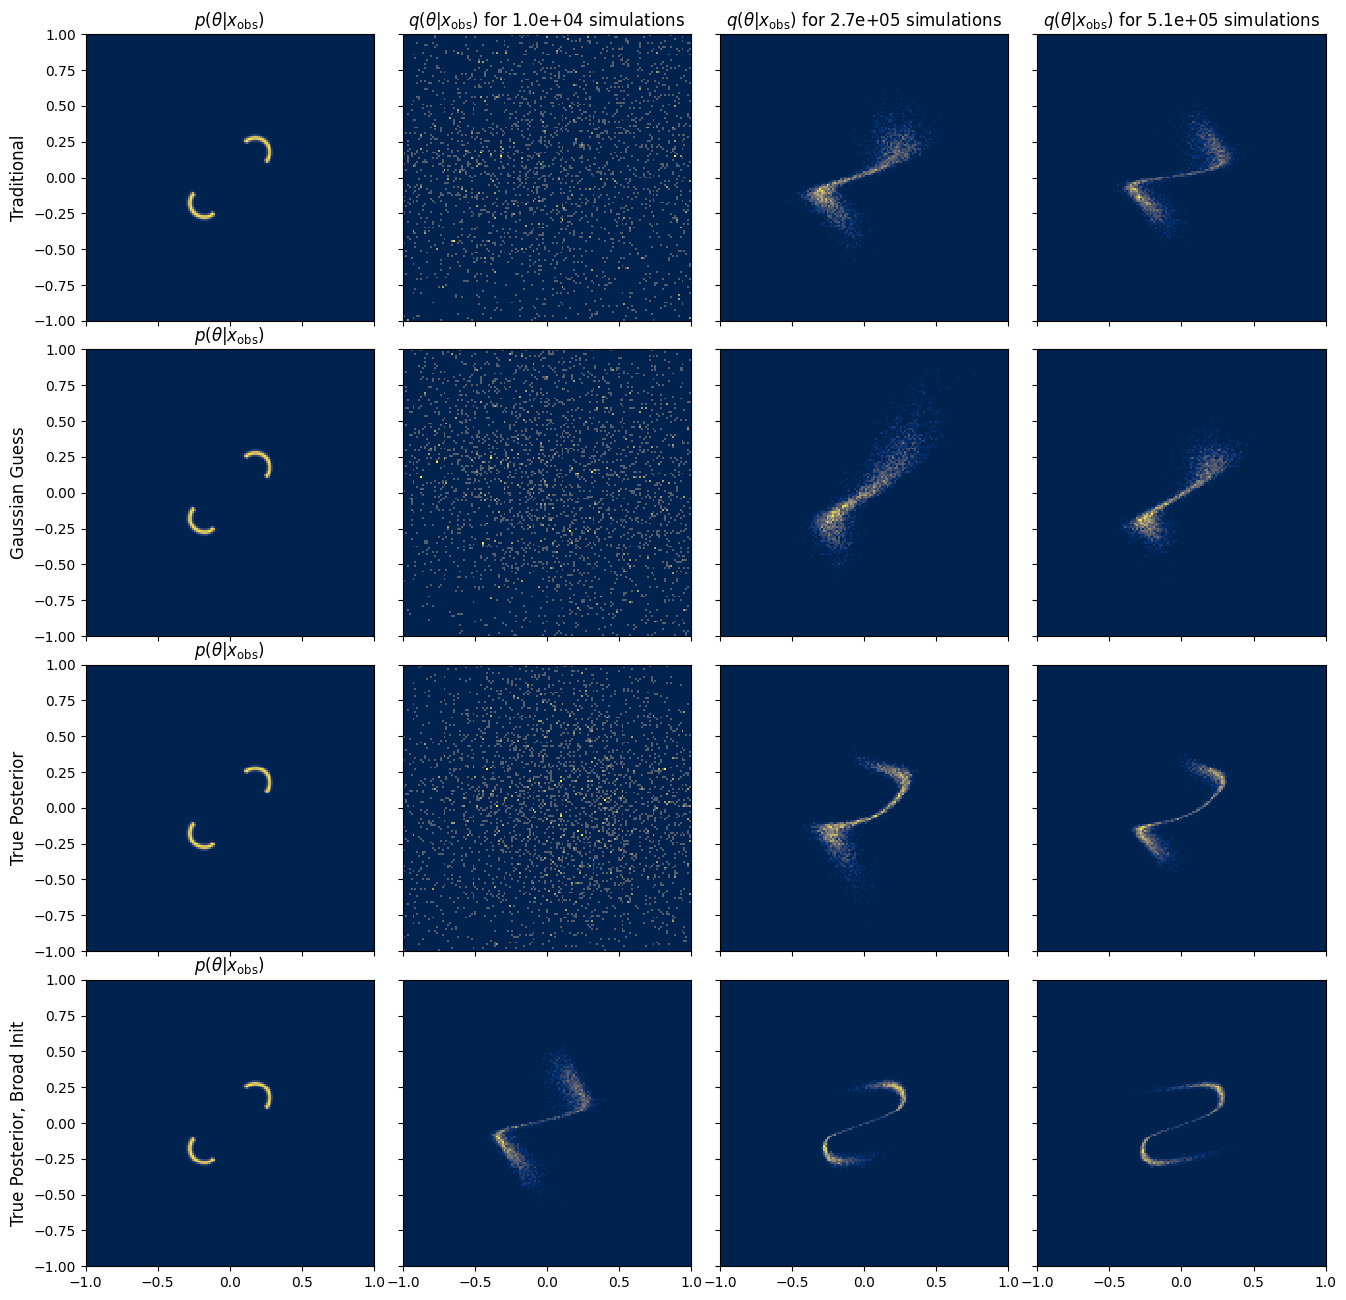

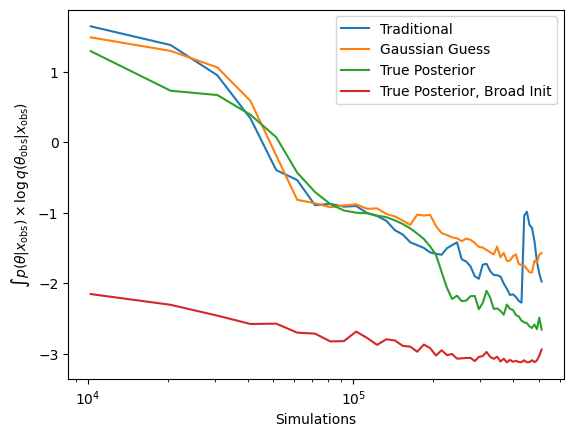

In [113]:
plt_indices = [0, 25, 49]
n_bins = 150
experiments = ['Traditional', 'Gaussian Guess', 'True Posterior', 'True Posterior, Broad Init']
theta_list = [theta_batch_samps, theta_batch_samps_gaus_guess, theta_batch_samps_true_post, theta_batch_samps_true_smart]
fontsize = 12

fig, ax = plt.subplots(
    len(experiments), len(plt_indices) + 1, figsize=(4 * (len(plt_indices) + 1), 4 * len(experiments)), sharey=True,
    sharex=True, gridspec_kw={'hspace': 0.1,'wspace':0.1}, dpi=100
)

for ex_i in range(len(experiments)):
    ax[ex_i, 0].set_title(r'$p(\theta|x_\mathrm{obs})$')
    ax[ex_i, 0].hist2d(
        theta_p_x[:, 0], theta_p_x[:, 1],
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
    ax[ex_i,0].set_ylabel(experiments[ex_i], fontsize=fontsize)

    for plt_i, i in enumerate(plt_indices):
        if ex_i == 0:
            ax[ex_i, plt_i+1].set_title(
                r'$q(\theta|x_\mathrm{obs})$ ' +
                f'for {batch_size * steps_per_epoch * (i+1):.1e} simulations',
                fontsize = fontsize
            )
        ax[ex_i, plt_i+1].hist2d(
            theta_list[ex_i][i][:, 0], theta_list[ex_i][i][:, 1],
            bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
        )
plt.show()

plt.plot(jnp.arange(1, n_steps// steps_per_epoch + 1) * steps_per_epoch * batch_size, jnp.array(kl))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch + 1) * steps_per_epoch * batch_size, jnp.array(kl_gaus_guess))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch + 1) * steps_per_epoch * batch_size, jnp.array(kl_true_post))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch + 1) * steps_per_epoch * batch_size, jnp.array(kl_true_smart))
plt.legend(experiments)
plt.xlabel('Simulations')
plt.xscale('log')
plt.ylabel(r'$\int p(\theta|x_\mathrm{obs}) \times \log q(\theta_\mathrm{obs}|x_\mathrm{obs})$')
plt.show()

In [18]:
batch_size = 512
rng = jax.random.PRNGKey(2)
mu_prior = jnp.zeros(2)
prec_prior = jnp.zeros((2, 2)) # Equivalent to uniform prior.

n_atoms = 128
n_steps = 40_000
warmup_steps = 5_000
max_width = len(str(n_steps))
sample_shape = (4096,)
steps_per_epoch = 1_000
theta_batch_samps_seq = []
x_batch_samps_seq = []
log_obs_probs_seq = []

x_obs = jnp.zeros((1, 2))
theta_obs = draw_param(jax.random.PRNGKey(0), x_obs[0])[None]

train_metrics_last_t = time.time()

# Create fresh state
state = train.create_train_state_nf(rng, optimizer, model, context_dim, parameter_dim, learning_rate_schedule)

for step in range(n_steps):

    # Sample a batch
    rng, _ = jax.random.split(rng)
    rng_batch = jax.random.split(rng, batch_size)
    if step < warmup_steps:
        theta_batch, x_batch = draw_batch(rng_batch)
    else:
        theta_batch, _ = sample_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            rng, x_obs, sample_shape=(batch_size,)
        )
        theta_batch = jnp.squeeze(theta_batch)
        x_batch = draw_obs_conds(rng_batch, theta_batch)
    batch = {'truth': theta_batch, 'context': x_batch}

    # Update
    state, metrics = train_step(
        rng, state, batch, mu_prior, prec_prior,
        learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms
    )
    if step > 0 and step % steps_per_epoch == 0:
        metrics['steps_per_second'] = (
            steps_per_epoch / (time.time() - train_metrics_last_t)
        )
        train_metrics_last_t = time.time()
        log_obs_prob, _ = log_prob_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            theta_obs, x_obs
        )
        metrics['log_obs_prob'] = log_obs_prob[0]
        print(f'step {step:>{max_width}}:', jax.tree_map(lambda x: f'{float(x):.3g}', metrics))
        t_samp, _ = sample_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            rng, x_obs,
            sample_shape=sample_shape
        )
        theta_batch_samps_seq.append(jnp.squeeze(t_samp))
        rng_sample = jax.random.split(rng, sample_shape[0])
        x_batch_samps_seq.append(draw_obs_conds(rng_sample, theta_batch_samps[-1]))
        log_obs_probs_seq.append(log_obs_prob)

step  1000: {'learning_rate': '0.0009', 'log_obs_prob': '0.0593', 'loss': '1.13', 'steps_per_second': '177'}
step  2000: {'learning_rate': '0.00081', 'log_obs_prob': '0.829', 'loss': '0.902', 'steps_per_second': '344'}
step  3000: {'learning_rate': '0.000729', 'log_obs_prob': '0.238', 'loss': '0.682', 'steps_per_second': '344'}
step  4000: {'learning_rate': '0.000656', 'log_obs_prob': '-0.148', 'loss': '0.54', 'steps_per_second': '344'}
step  5000: {'learning_rate': '0.00059', 'log_obs_prob': '0.71', 'loss': '4', 'steps_per_second': '344'}
step  6000: {'learning_rate': '0.000531', 'log_obs_prob': '1.62', 'loss': '3.55', 'steps_per_second': '329'}
step  7000: {'learning_rate': '0.000478', 'log_obs_prob': '1.49', 'loss': '3.4', 'steps_per_second': '329'}
step  8000: {'learning_rate': '0.00043', 'log_obs_prob': '1.05', 'loss': '3.36', 'steps_per_second': '329'}
step  9000: {'learning_rate': '0.000387', 'log_obs_prob': '2.38', 'loss': '3.39', 'steps_per_second': '329'}
step 10000: {'learni

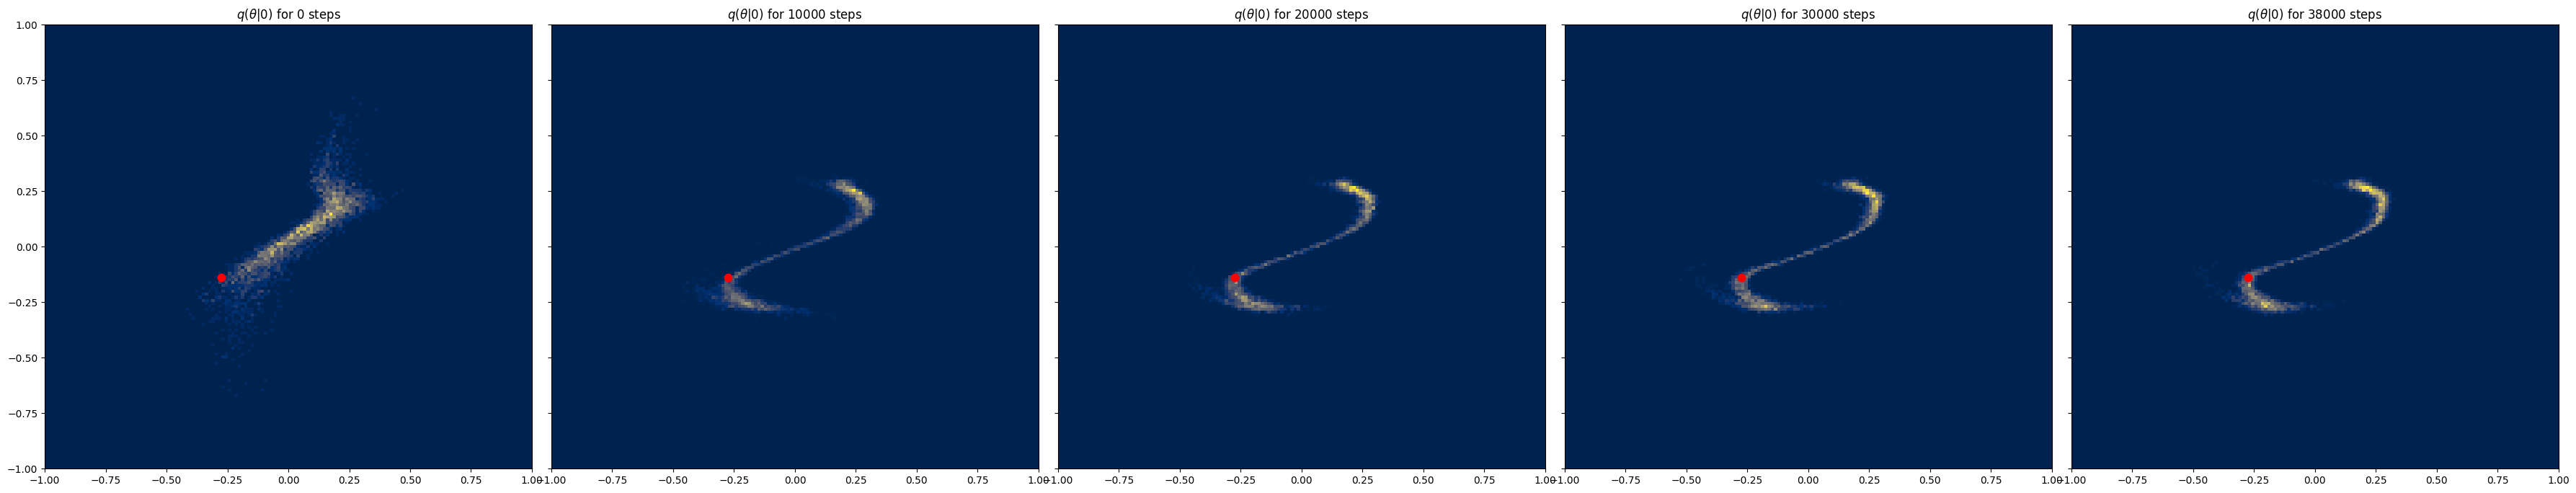

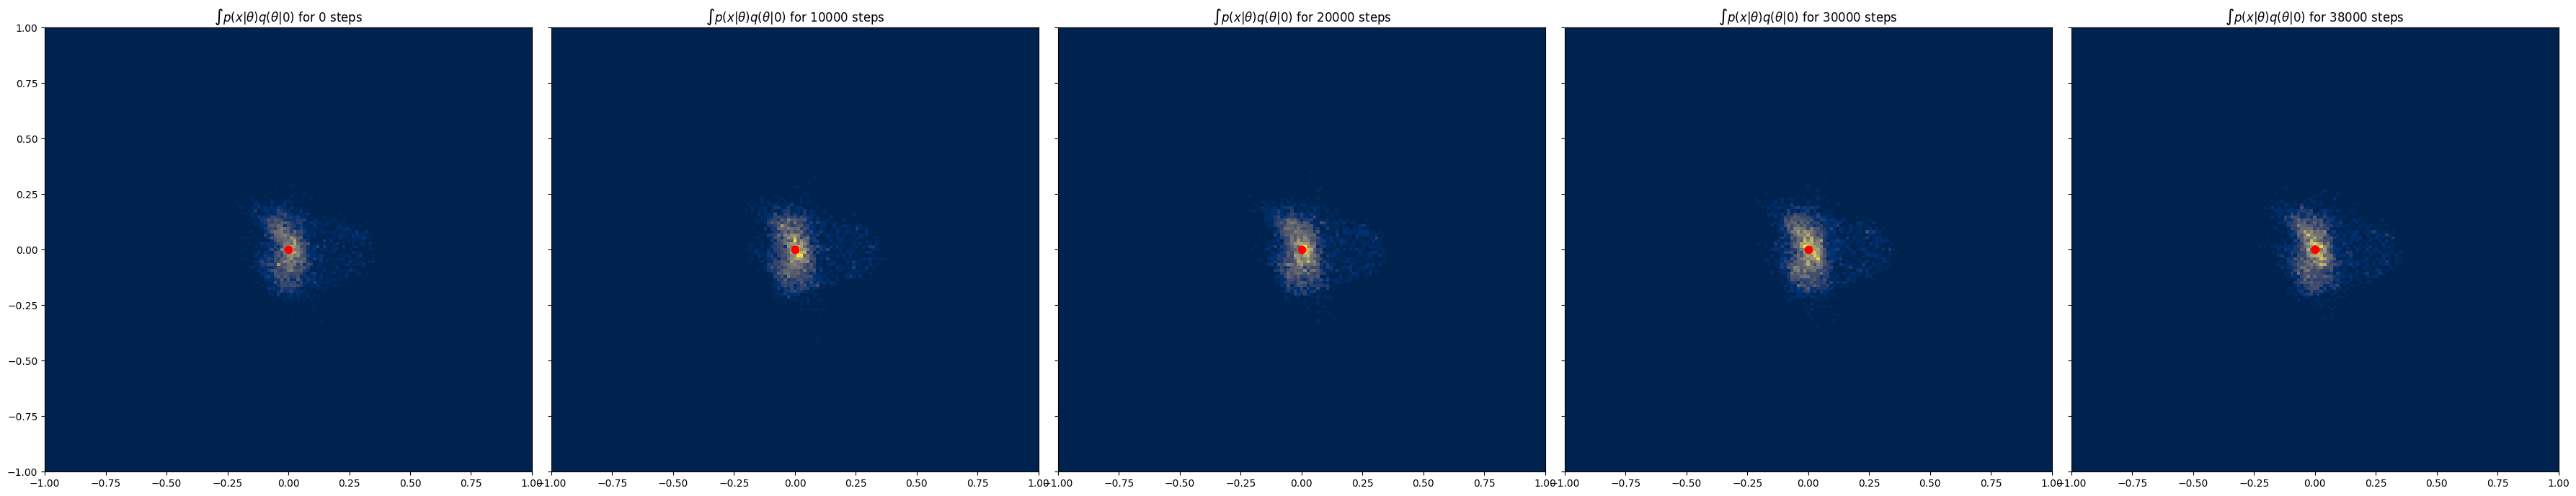

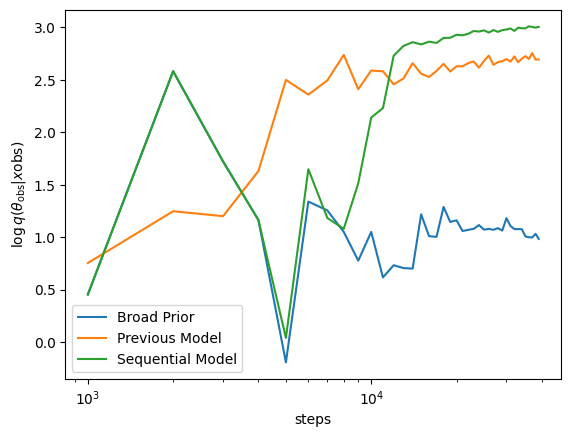

In [52]:
plt_indices = [0, 10, 20, 30, 38]
fig, ax = plt.subplots(
    1, len(plt_indices), figsize=(9 * len(plt_indices),8), sharey=True,
    gridspec_kw={'hspace': 0.02,'wspace':0.04}, dpi=100
)
n_bins = 150
for plt_i, i in enumerate(plt_indices):
    ax[plt_i].set_title(r'$q(\theta|0)$ ' + f'for {steps_per_epoch * i} steps')
    ax[plt_i].hist2d(
        theta_batch_samps_seq[i][:, 0], theta_batch_samps_seq[i][:, 1],
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
    ax[plt_i].plot(theta_obs[0, 0], theta_obs[0, 1],'.', color='red', markersize=15)
plt.show()

fig, ax = plt.subplots(
    1, len(plt_indices), figsize=(9 * len(plt_indices),8), sharey=True,
    gridspec_kw={'hspace': 0.02,'wspace':0.04}, dpi=100
)
for plt_i, i in enumerate(plt_indices):
    ax[plt_i].set_title(r'$\int p(x|\theta)q(\theta|0)$ ' + f'for {steps_per_epoch * i} steps')
    ax[plt_i].hist2d(
        x_batch_samps_seq[i][:, 0], x_batch_samps_seq[i][:, 1],
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
    ax[plt_i].plot(x_obs[0, 0], x_obs[0, 1],'.', color='red', markersize=15)
plt.show()

plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs_cond))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs_seq))
plt.legend(['Broad Prior', 'Previous Model', 'Sequential Model'])
plt.xlabel('steps')
plt.xscale('log')
plt.ylabel(r'$\log q(\theta_\mathrm{obs}|x\mathrm{obs})$')
plt.show()

In [54]:
batch_size = 512
rng = jax.random.PRNGKey(2)
mu_prior = jnp.zeros(2)
prec_prior = jnp.zeros((2, 2)) # Equivalent to uniform prior.

n_atoms = 128
n_steps = 40_000
max_width = len(str(n_steps))
sample_shape = (4096,)
steps_per_epoch = 1_000
theta_batch_samps_gauss = []
x_batch_samps_gauss = []
log_obs_probs_gauss = []

x_obs = jnp.zeros((1, 2))
theta_obs = draw_param(jax.random.PRNGKey(0), x_obs[0])[None]

train_metrics_last_t = time.time()

# Create fresh state
state = train.create_train_state_nf(rng, optimizer, model, context_dim, parameter_dim, learning_rate_schedule)

for step in range(n_steps):

    # Sample a batch
    rng, _ = jax.random.split(rng)
    rng_batch = jax.random.split(rng, batch_size)
    theta_batch = jax.random.multivariate_normal(
        rng, mean=jnp.zeros(2), cov=jnp.array([[0.5, 0.4], [0.4, 0.5]]), shape=(batch_size,)
    )
    x_batch = draw_obs_conds(rng_batch, theta_batch)
    batch = {'truth': theta_batch, 'context': x_batch}

    # Update
    state, metrics = train_step(
        rng, state, batch, mu_prior, prec_prior,
        learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms
    )
    if step > 0 and step % steps_per_epoch == 0:
        metrics['steps_per_second'] = (
            steps_per_epoch / (time.time() - train_metrics_last_t)
        )
        train_metrics_last_t = time.time()
        log_obs_prob, _ = log_prob_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            theta_obs, x_obs
        )
        metrics['log_obs_prob'] = log_obs_prob[0]
        print(f'step {step:>{max_width}}:', jax.tree_map(lambda x: f'{float(x):.3g}', metrics))
        t_samp, _ = sample_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            rng, x_obs,
            sample_shape=sample_shape
        )
        theta_batch_samps_gauss.append(jnp.squeeze(t_samp))
        rng_sample = jax.random.split(rng, sample_shape[0])
        x_batch_samps_gauss.append(draw_obs_conds(rng_sample, theta_batch_samps[-1]))
        log_obs_probs_gauss.append(log_obs_prob)

step  1000: {'learning_rate': '0.0009', 'log_obs_prob': '3.08', 'loss': '1.61', 'steps_per_second': '201'}
step  2000: {'learning_rate': '0.00081', 'log_obs_prob': '2.99', 'loss': '1.33', 'steps_per_second': '428'}
step  3000: {'learning_rate': '0.000729', 'log_obs_prob': '1.88', 'loss': '1.36', 'steps_per_second': '429'}
step  4000: {'learning_rate': '0.000656', 'log_obs_prob': '1.94', 'loss': '1.21', 'steps_per_second': '427'}
step  5000: {'learning_rate': '0.00059', 'log_obs_prob': '2.08', 'loss': '1.11', 'steps_per_second': '428'}
step  6000: {'learning_rate': '0.000531', 'log_obs_prob': '2.21', 'loss': '1.14', 'steps_per_second': '430'}
step  7000: {'learning_rate': '0.000478', 'log_obs_prob': '2.08', 'loss': '1.11', 'steps_per_second': '429'}
step  8000: {'learning_rate': '0.00043', 'log_obs_prob': '1.55', 'loss': '1.18', 'steps_per_second': '426'}
step  9000: {'learning_rate': '0.000387', 'log_obs_prob': '1.77', 'loss': '1.04', 'steps_per_second': '430'}
step 10000: {'learning_r

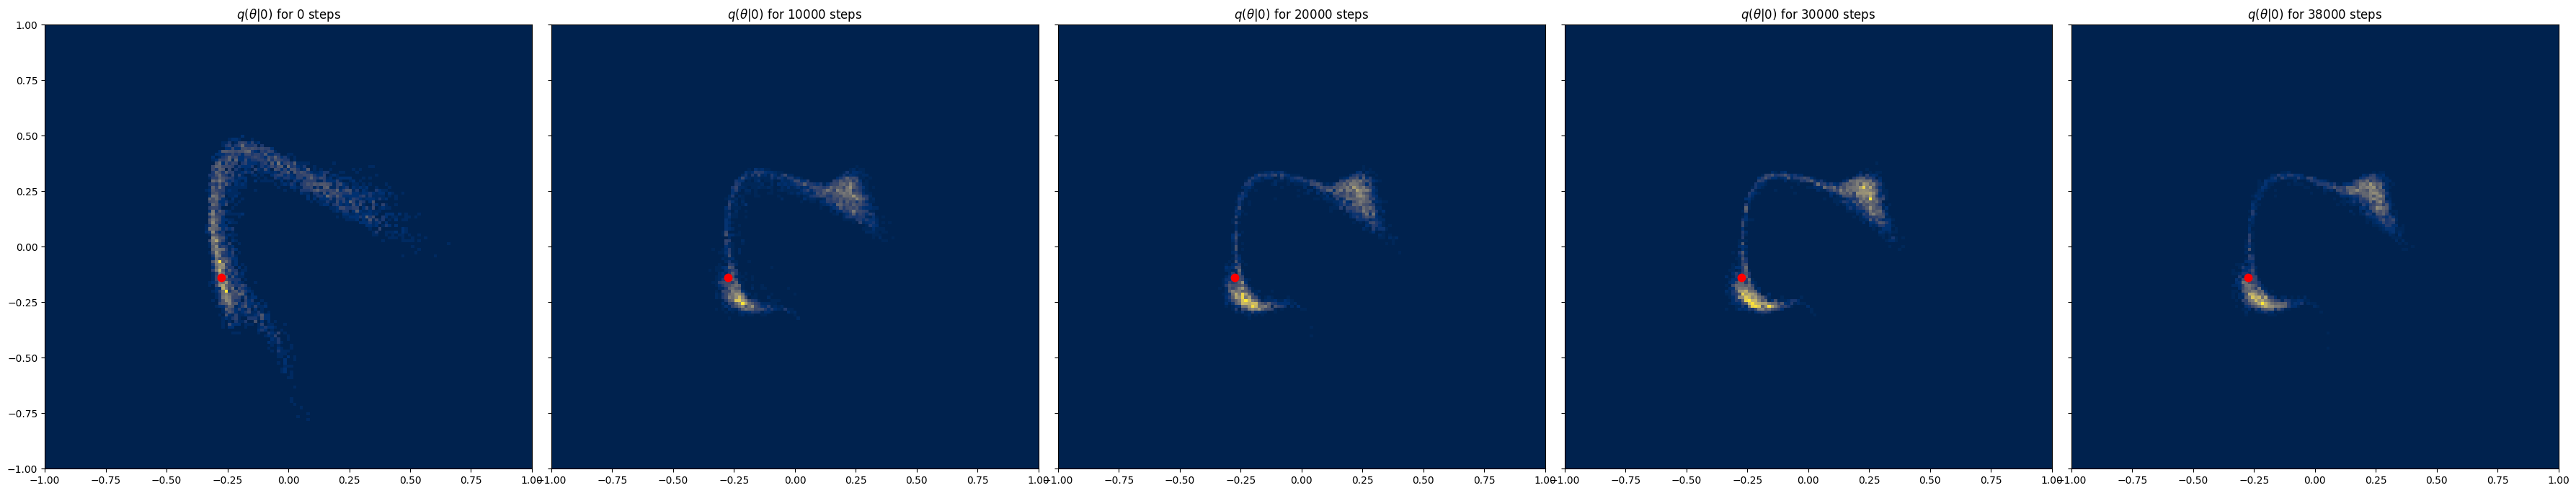

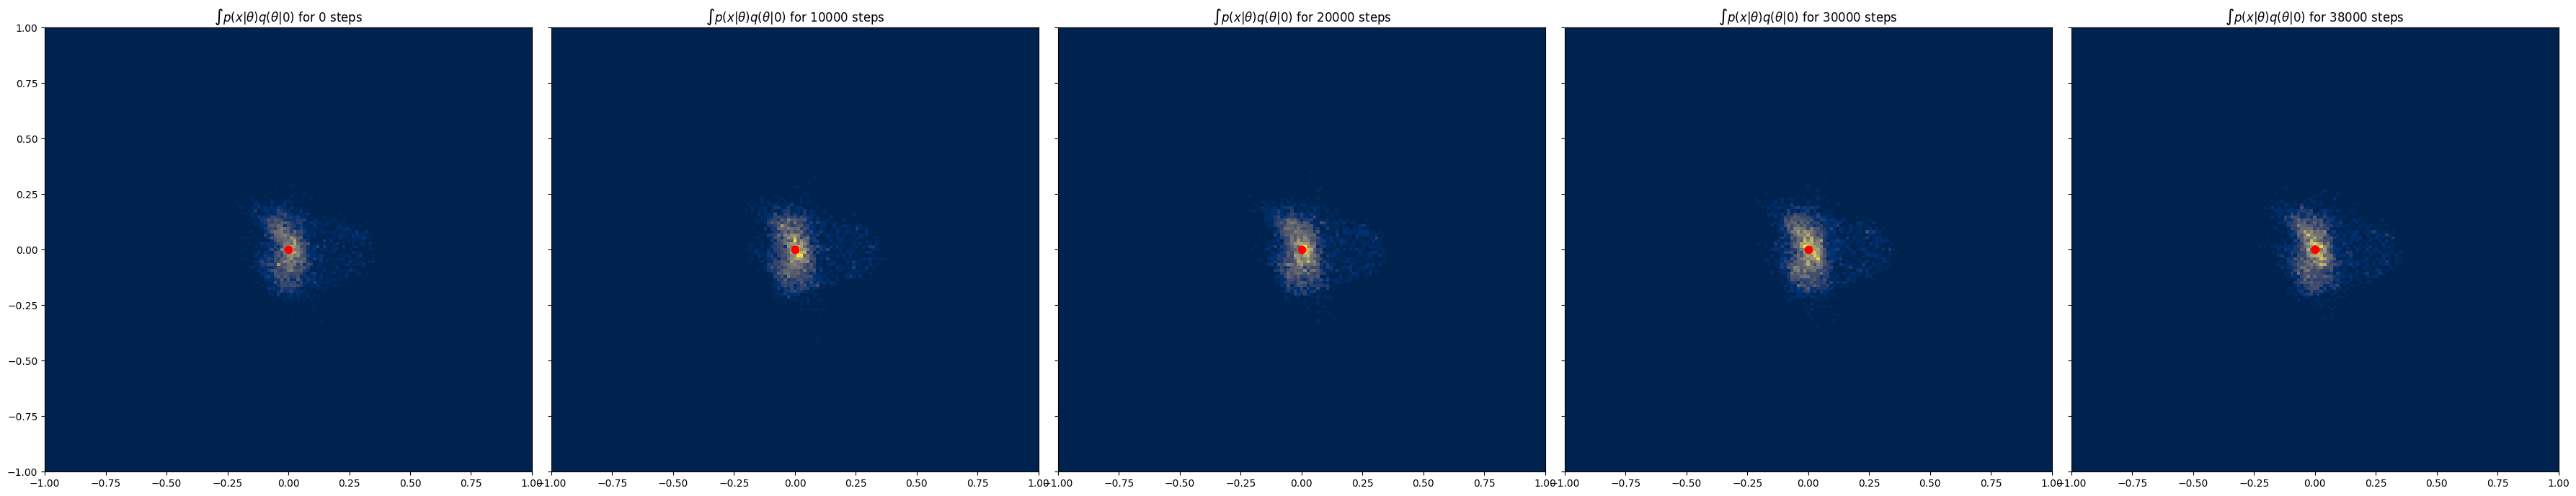

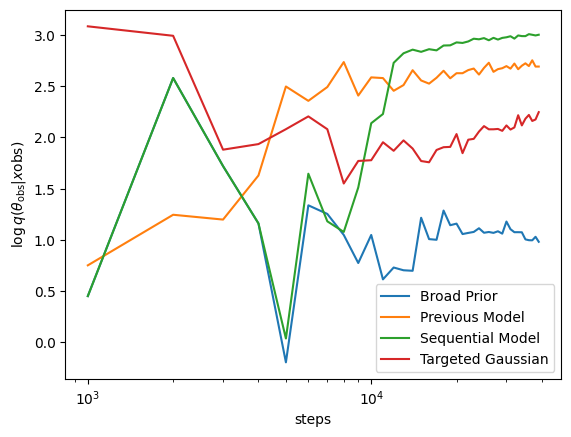

In [55]:
plt_indices = [0, 10, 20, 30, 38]
fig, ax = plt.subplots(
    1, len(plt_indices), figsize=(9 * len(plt_indices),8), sharey=True,
    gridspec_kw={'hspace': 0.02,'wspace':0.04}, dpi=100
)
n_bins = 150
for plt_i, i in enumerate(plt_indices):
    ax[plt_i].set_title(r'$q(\theta|0)$ ' + f'for {steps_per_epoch * i} steps')
    ax[plt_i].hist2d(
        theta_batch_samps_gauss[i][:, 0], theta_batch_samps_gauss[i][:, 1],
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
    ax[plt_i].plot(theta_obs[0, 0], theta_obs[0, 1],'.', color='red', markersize=15)
plt.show()

fig, ax = plt.subplots(
    1, len(plt_indices), figsize=(9 * len(plt_indices),8), sharey=True,
    gridspec_kw={'hspace': 0.02,'wspace':0.04}, dpi=100
)
for plt_i, i in enumerate(plt_indices):
    ax[plt_i].set_title(r'$\int p(x|\theta)q(\theta|0)$ ' + f'for {steps_per_epoch * i} steps')
    ax[plt_i].hist2d(
        x_batch_samps_gauss[i][:, 0], x_batch_samps_gauss[i][:, 1],
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
    ax[plt_i].plot(x_obs[0, 0], x_obs[0, 1],'.', color='red', markersize=15)
plt.show()

plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs_cond))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs_seq))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs_gauss))
plt.legend(['Broad Prior', 'Previous Model', 'Sequential Model', 'Targeted Gaussian'])
plt.xlabel('steps')
plt.xscale('log')
plt.ylabel(r'$\log q(\theta_\mathrm{obs}|x\mathrm{obs})$')
plt.show()

In [ ]:
batch_size = 512
rng = jax.random.PRNGKey(2)
mu_prior = jnp.zeros(2)
prec_prior = jnp.zeros((2, 2)) # Equivalent to uniform prior.

n_atoms = 128
n_steps = 40_000
max_width = len(str(n_steps))
sample_shape = (4096,)
steps_per_epoch = 1_000
theta_batch_samps_two_gauss = []
x_batch_samps_two_gauss = []
log_obs_probs_two_gauss = []

x_obs = jnp.zeros((1, 2))
theta_obs = draw_param(jax.random.PRNGKey(0), x_obs[0])[None]

train_metrics_last_t = time.time()

# Create fresh state
state = train.create_train_state_nf(rng, optimizer, model, context_dim, parameter_dim, learning_rate_schedule)

for step in range(n_steps):

    # Sample a batch
    rng, _ = jax.random.split(rng)
    rng_batch = jax.random.split(rng, batch_size)
    theta_batch = jnp.concatenate(
        [
            jax.random.multivariate_normal(
                rng, mean=jnp.array([-0.2, -0.2]), cov=jnp.array([[0.05, -0.03], [-0.03, 0.05]]),
                shape=(batch_size // 2,)
            ),
            jax.random.multivariate_normal(
                rng, mean=jnp.array([0.25, 0.25]), cov=jnp.array([[0.05, -0.03], [-0.03, 0.05]]),
                shape=(batch_size // 2,)
            )
        ],
        axis=0
    )
    x_batch = draw_obs_conds(rng_batch, theta_batch)
    batch = {'truth': theta_batch, 'context': x_batch}

    # Update
    state, metrics = train_step(
        rng, state, batch, mu_prior, prec_prior,
        learning_rate_schedule=learning_rate_schedule, n_atoms=n_atoms
    )
    if step > 0 and step % steps_per_epoch == 0:
        metrics['steps_per_second'] = (
            steps_per_epoch / (time.time() - train_metrics_last_t)
        )
        train_metrics_last_t = time.time()
        log_obs_prob, _ = log_prob_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            theta_obs, x_obs
        )
        metrics['log_obs_prob'] = log_obs_prob[0]
        print(f'step {step:>{max_width}}:', jax.tree_map(lambda x: f'{float(x):.3g}', metrics))
        t_samp, _ = sample_func(
            {'params': state.params, 'batch_stats': state.batch_stats},
            rng, x_obs,
            sample_shape=sample_shape
        )
        theta_batch_samps_two_gauss.append(jnp.squeeze(t_samp))
        rng_sample = jax.random.split(rng, sample_shape[0])
        x_batch_samps_two_gauss.append(draw_obs_conds(rng_sample, theta_batch_samps[-1]))
        log_obs_probs_two_gauss.append(log_obs_prob)

step  1000: {'learning_rate': '0.0009', 'log_obs_prob': '2.7', 'loss': '2.61', 'steps_per_second': '172'}
step  2000: {'learning_rate': '0.00081', 'log_obs_prob': '2.7', 'loss': '2.6', 'steps_per_second': '317'}
step  3000: {'learning_rate': '0.000729', 'log_obs_prob': '2.71', 'loss': '2.27', 'steps_per_second': '317'}
step  4000: {'learning_rate': '0.000656', 'log_obs_prob': '3.16', 'loss': '1.74', 'steps_per_second': '317'}
step  5000: {'learning_rate': '0.00059', 'log_obs_prob': '3.3', 'loss': '1.63', 'steps_per_second': '318'}
step  6000: {'learning_rate': '0.000531', 'log_obs_prob': '3.4', 'loss': '1.71', 'steps_per_second': '317'}
step  7000: {'learning_rate': '0.000478', 'log_obs_prob': '3.46', 'loss': '1.69', 'steps_per_second': '318'}
step  8000: {'learning_rate': '0.00043', 'log_obs_prob': '3.48', 'loss': '1.54', 'steps_per_second': '317'}
step  9000: {'learning_rate': '0.000387', 'log_obs_prob': '3.51', 'loss': '1.66', 'steps_per_second': '316'}
step 10000: {'learning_rate':

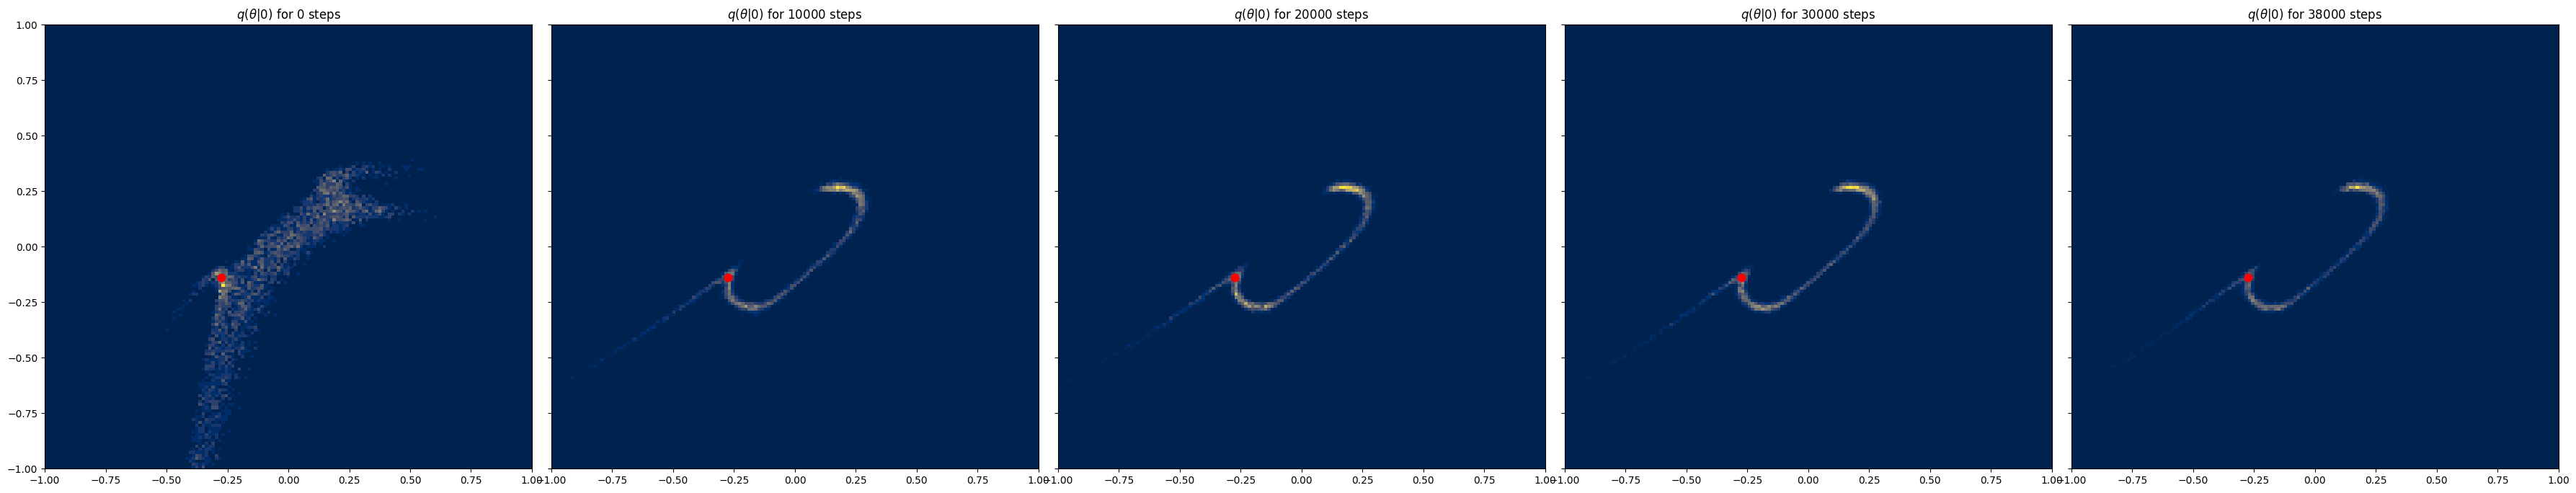

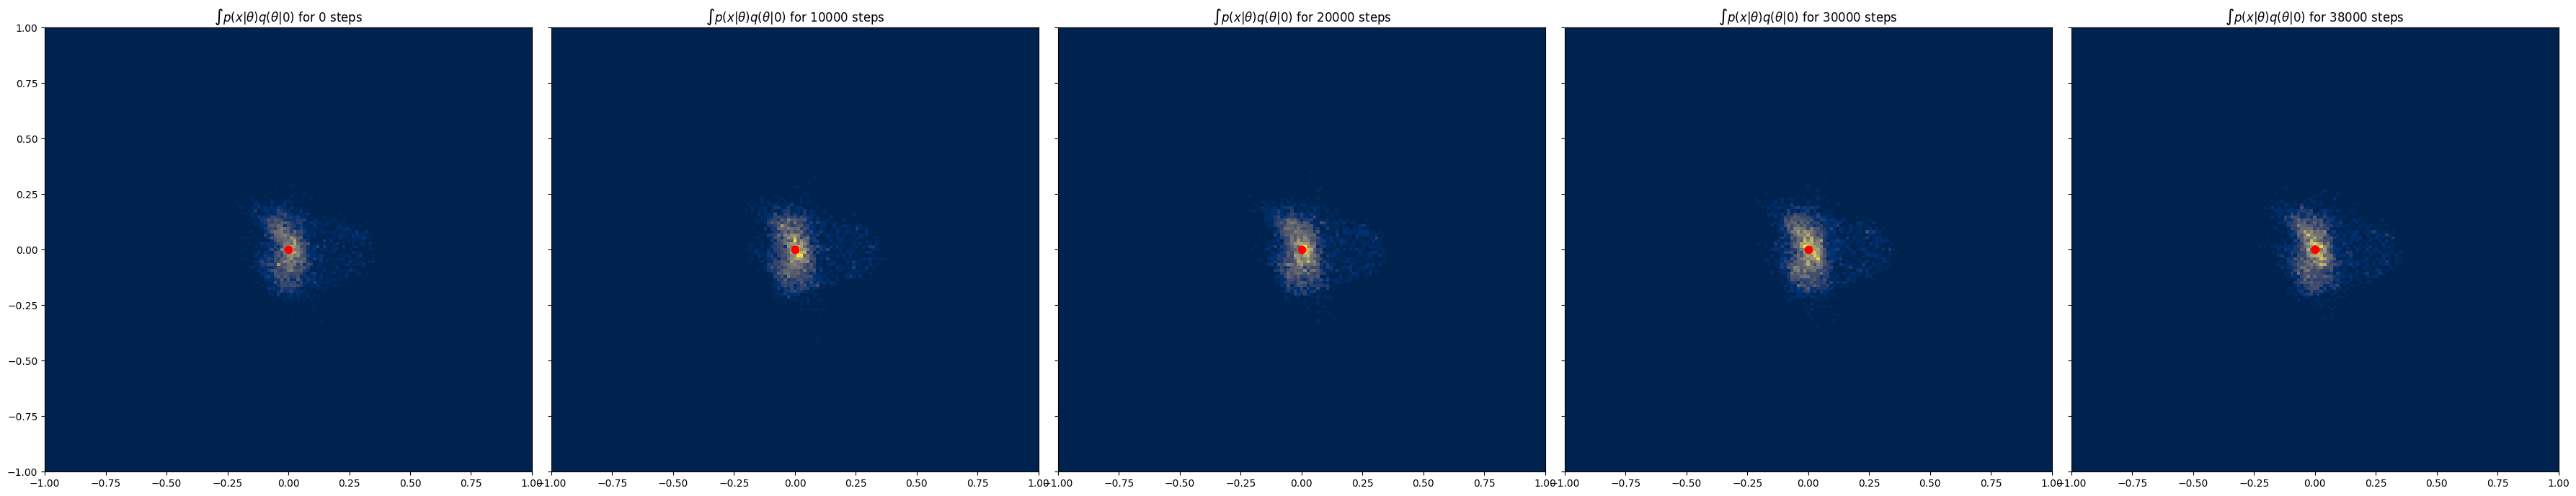

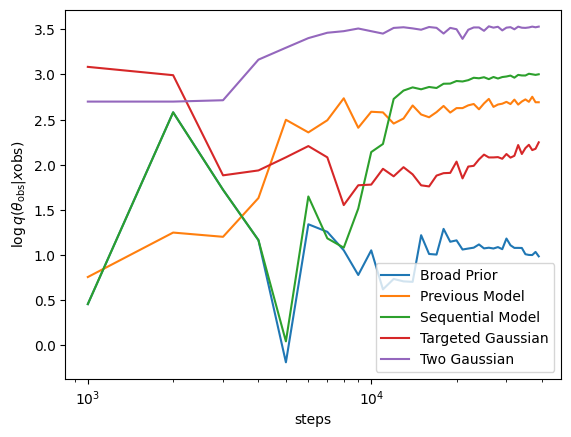

In [59]:
plt_indices = [0, 10, 20, 30, 38]
fig, ax = plt.subplots(
    1, len(plt_indices), figsize=(9 * len(plt_indices),8), sharey=True,
    gridspec_kw={'hspace': 0.02,'wspace':0.04}, dpi=100
)
n_bins = 150
for plt_i, i in enumerate(plt_indices):
    ax[plt_i].set_title(r'$q(\theta|0)$ ' + f'for {steps_per_epoch * i} steps')
    ax[plt_i].hist2d(
        theta_batch_samps_two_gauss[i][:, 0], theta_batch_samps_two_gauss[i][:, 1],
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
    ax[plt_i].plot(theta_obs[0, 0], theta_obs[0, 1],'.', color='red', markersize=15)
plt.show()

fig, ax = plt.subplots(
    1, len(plt_indices), figsize=(9 * len(plt_indices),8), sharey=True,
    gridspec_kw={'hspace': 0.02,'wspace':0.04}, dpi=100
)
for plt_i, i in enumerate(plt_indices):
    ax[plt_i].set_title(r'$\int p(x|\theta)q(\theta|0)$ ' + f'for {steps_per_epoch * i} steps')
    ax[plt_i].hist2d(
        x_batch_samps_two_gauss[i][:, 0], x_batch_samps_two_gauss[i][:, 1],
        bins=[jnp.linspace(-1, 1, n_bins), jnp.linspace(-1, 1, n_bins)], cmap='cividis'
    )
    ax[plt_i].plot(x_obs[0, 0], x_obs[0, 1],'.', color='red', markersize=15)
plt.show()

plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs_cond))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs_seq))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs_gauss))
plt.plot(jnp.arange(1, n_steps// steps_per_epoch) * steps_per_epoch, jnp.array(log_obs_probs_two_gauss))
plt.legend(['Broad Prior', 'Previous Model', 'Sequential Model', 'Targeted Gaussian', 'Two Gaussian'])
plt.xlabel('steps')
plt.xscale('log')
plt.ylabel(r'$\log q(\theta_\mathrm{obs}|x\mathrm{obs})$')
plt.show()